# Activation Variance Shift

## <font color = blue> Activation

- ReLU function
- Swish function
- Hard Swish function
- Sigmoid function
    
***    
## <font color=blue> Problem Setting

Without loss of generality, input x has `zero mean` and `some value of sigma`.

***    
## <font color=blue> 0. Input Sigma

Fix the mean of x as zero, and then observe the sigma shift when changing the x sigma.

In [2]:
import os
import time
import argparse
import shutil
import math

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from thop import profile
import matplotlib.pyplot as plt

from Utils import *
from Models import *

In [3]:
input_std = np.linspace(0,1,1000)

In [4]:
def act_std(input_std, func):
    act_std = []
    mean = []
    for std in input_std:
        x = torch.randn(100000) *std
        act_std.append(func(x).std())
        mean.append(func(x).mean())
    
    return mean, act_std

***    
## <font color=blue> 1. ReLU

In [13]:
relu = nn.ReLU()

In [14]:
re_m, re_act_std = act_std(input_std, relu)

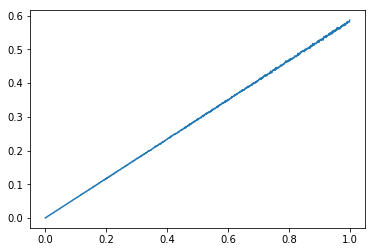

In [15]:
plt.plot(input_std, re_act_std)

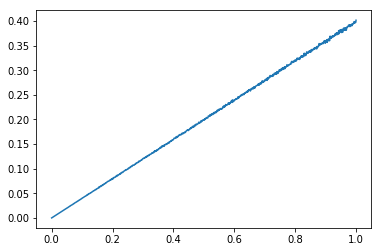

In [16]:
plt.plot(input_std, re_m)

In [33]:
max(re_act_std), max(re_m)

(tensor(0.5867), tensor(0.4016))

***    
## <font color=blue> 2. Swish

In [19]:
class Swish(nn.Module):
    """
    Swish activation function 
    Parameters:
    ----------
    inplace : bool
        Whether to use inplace version of the module.
    """
    def __init__(self, inplace=True):
        super(Swish, self).__init__()
        self.inplace = inplace
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

In [20]:
swish = Swish()

In [21]:
sw_m, sw_act_std = act_std(input_std, swish)

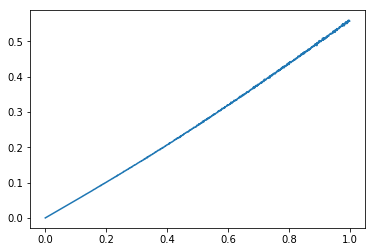

In [22]:
plt.plot(input_std, sw_act_std)

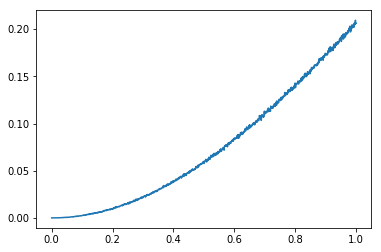

In [23]:
plt.plot(input_std, sw_m)

In [34]:
max(sw_m), max(sw_act_std)

(tensor(0.2094), tensor(0.5601))

***    
## <font color=blue> 3. Hard Swish

In [18]:
class HSwish(nn.Module):
    """
    H-Swish activation function from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.
    Parameters:
    ----------
    inplace : bool
        Whether to use inplace version of the module.
    """
    def __init__(self, inplace=True):
        super(HSwish, self).__init__()
        self.inplace = inplace
        self.relu = nn.ReLU6(inplace = self.inplace)

    def forward(self, x):
        return x * self.relu(x + 3.0) / 6.0

In [24]:
hswish = HSwish()

In [25]:
hsw_m, hsw_act_std = act_std(input_std, hswish)

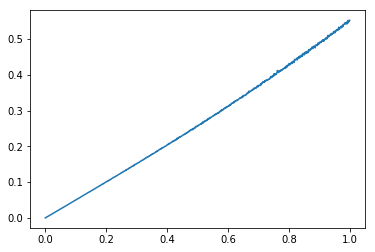

In [26]:
plt.plot(input_std, hsw_act_std)

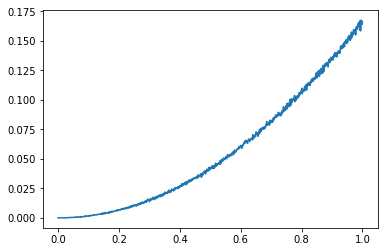

In [27]:
plt.plot(input_std, hsw_m)

In [35]:
max(hsw_m), max(hsw_act_std)

(tensor(0.1674), tensor(0.5522))

***    
## <font color=blue> 4. Sigmoid

In [28]:
sigmoid = nn.Sigmoid()

In [29]:
sig_m, sig_act_std = act_std(input_std, sigmoid)

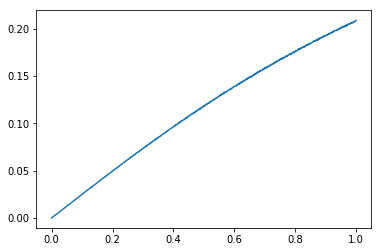

In [30]:
plt.plot(input_std, sig_act_std)

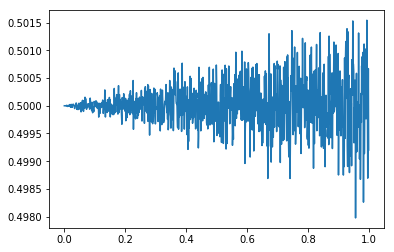

In [31]:
plt.plot(input_std, sig_m)

***    
## <font color=blue> Summary

    when input_std = x,
- ReLU
    
    - mean: 0.4016 * x
    
    - std: 0.5867 * x
- Swish
    
    - mean: 0.2094 * x^2
    
    - std: 0.5601 * x
- Hard Swish
    - mean: 0.165 * x^2
    
    - std: 0.5502 * x
    
- Sigmoid
    - mean : 0.5
    
    - std : 뭔가 log 함수...
  

***    
## <font color=blue> Derivative of activation function

***    
## <font color=blue> 1. Hard Swish

In [42]:
def deriv(x):
    for i in range(len(x)):
        if x[i] < 0:
            x[i] = 0
        elif 0 <=x[i] < 6:
            x[i] = 1
        elif 6 <=x[i]:
            x[i] = 0
    return x

In [48]:
class HSwish_deriv(nn.Module):
    """
    H-Swish activation function from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.
    Parameters:
    ----------
    inplace : bool
        Whether to use inplace version of the module.
    """
    def __init__(self, inplace=True):
        super(HSwish_deriv, self).__init__()
        self.inplace = inplace
        self.relu = nn.ReLU6(inplace = self.inplace)

    def forward(self, x):
        return self.relu(x + 3.0) / 6.0 + x * deriv(x+3)/6

In [49]:
h_deriv = HSwish_deriv()

In [50]:
h_deriv_m, h_deriv_act_std = act_std(input_std, h_deriv)

KeyboardInterrupt: 

In [ ]:
plt.plot(input_std, h_deriv_act_std)

In [ ]:
plt.plot(input_std, h_deriv_m)

***    
## <font color=blue> 2. Swish

In [54]:
class Swish_dev(nn.Module):
    """
    H-Swish activation function from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.
    Parameters:
    ----------
    inplace : bool
        Whether to use inplace version of the module.
    """
    def __init__(self, inplace=True):
        super(Swish_dev, self).__init__()
        self.inplace = inplace
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(x) + x * torch.exp(-x) * (self.sigmoid(x) * self.sigmoid(x))

In [55]:
s_deriv = Swish_dev()

In [56]:
h_deriv_m, h_deriv_act_std = act_std(input_std, s_deriv)

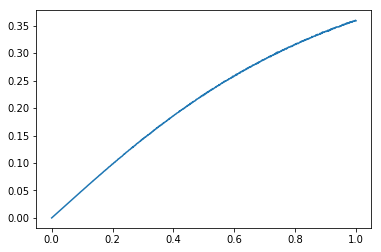

In [57]:
plt.plot(input_std, h_deriv_act_std)

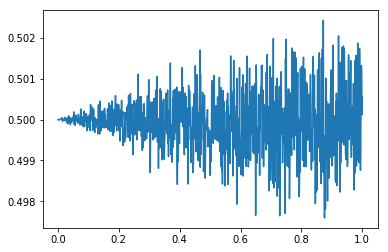

In [58]:
plt.plot(input_std, h_deriv_m)

In [59]:
max(h_deriv_act_std)

tensor(0.3599)